<a href="https://colab.research.google.com/github/Sokratis1000/time-series-forcasting/blob/master/1990's_including_economic_features_as_known_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 4.9 MB/s 
     |████████████████████████████████| 529 kB 55.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 4.3 MB/s 
     |████████████████████████████████| 308 kB 39.9 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 209 kB 55.2 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 112 kB 71.9 MB/s 
     |████████████████████████████████| 147 kB 50.8 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=309c5d65c741333be9ad0c2467e6a471549e23db4edb77c95880f95b4f9ab642
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae

In [ ]:
#https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import copy


import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving From_1990.csv to From_1990.csv


In [ ]:
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(data_to_load['From_1990.csv']),encoding = "ISO-8859-1")

In [ ]:
data['Date']=pd.to_datetime(data['Date'])

In [ ]:
# add time index
data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
data["time_idx"] -= data["time_idx"].min()
# add additional features
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_Construction_Employment_State"] = np.log(data.Construction_Employment_State + 1e-8)
data["avg_volume_by_state"] = data.groupby(["time_idx", "State"], observed=True).Construction_Employment_State.transform("mean")



#we want to encode special days as one variable and thus need to first reverse one-hot encoding
Extreme_Events=[
"Recession",
]
data[Extreme_Events] = data[Extreme_Events].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,State,Date,Construction_Employment_State,Coincident_Economic_Activity_State,Labor_Force_Participation_State,Permits_Housing_State,Unemployment_Rate_State,Property_Damage_State,Construction_Employment_US,PPI_Machinary_US,...,Dist_Wyoming,Risk_index,Expected_Loss_per_Capita,Annual_Expected_Losses_Millions,Greatest_Potential_Hazard,Building_Losses_Percent,time_idx,month,log_Construction_Employment_State,avg_volume_by_state
16496,Washington,2017-06-01,200.30,133.15,63.8,1918.19,4.6,0,6962,220.9,...,844.11,14.56,150.54,1012,Earthquake,0.64,329,6,5.299816,200.30
14227,Nevada,2013-09-01,57.90,101.50,63.5,773.02,9.6,1050000,5910,211.1,...,568.63,16.26,128.41,347,Earthquake,0.53,284,9,4.058717,57.90
5425,Montana,1999-01-01,19.80,76.19,68.8,92.68,5.5,25000,6357,146.2,...,322.89,6.83,89.82,89,Earthquake,0.37,108,1,2.985682,19.80
6576,Nebraska,2000-12-01,42.53,86.75,73.3,457.97,2.9,0,6792,148.9,...,398.75,9.43,242.24,442,Tornado,0.36,131,12,3.750210,42.53
6271,Michigan,2000-06-01,212.30,105.10,68.7,3348.62,3.7,4100000,6778,148.6,...,976.44,7.65,36.94,365,Strong Wind,0.60,125,6,5.358000,212.30
18192,Texas,2020-04-01,724.20,137.06,59.8,8972.04,12.6,10000000,6516,236.6,...,824.13,12.89,183.53,4615,Hurricane,0.68,363,4,6.585068,724.20
1918,Maine,1993-03-01,21.10,73.74,66.5,240.89,6.7,0,4676,132.3,...,1530.42,8.72,41.00,54,Drought,0.47,38,3,3.049273,21.10
13436,Oregon,2012-05-01,69.70,105.73,63.7,604.55,8.9,0,5604,205.1,...,822.12,15.53,154.29,591,Earthquake,0.63,268,5,4.244200,69.70
8894,Vermont,2004-10-01,16.70,95.82,70.3,209.07,3.5,0,7077,162.4,...,1399.21,5.73,39.53,25,Riverine Flooding,0.72,177,10,2.815409,16.70
9839,South Carolina,2006-05-01,124.80,94.76,65.0,3569.19,7.0,2450000,7713,175.3,...,1290.61,12.78,98.01,453,Earthquake,0.53,196,5,4.826712,124.80


In [ ]:

max_prediction_length = 6
max_encoder_length = 24
#min_prediction_idx=300
training_cutoff = data["time_idx"].max() - max_prediction_length
validation_start=data["time_idx"].max() - max_prediction_length - max_encoder_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Construction_Employment_State",
    group_ids=["State"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["State"],
    static_reals=["Dist_Alabama","Dist_Alaska","Dist_Arkansas","Dist_California","Dist_Colorado","Dist_Connecticut","Dist_Delaware","Dist_Florida","Dist_Georgia","Dist_Hawaii","Dist_Idaho","Dist_Illinois","Dist_Indiana","Dist_Kansas","Dist_Kentucky","Dist_Louisiana","Dist_Maine","Dist_Maryland","Dist_Massachusetts","Dist_Michigan","Dist_Minnesota","Dist_Mississippi","Dist_Missouri","Dist_Montana","Dist_Nebraska","Dist_NewHampshire","Dist_Nevada","Dist_NewJersey","Dist_NewMexico","Dist_NewYork","Dist_NorthCarolina","Dist_NorthDakota","Dist_Ohio","Dist_Oklahoma","Dist_Oregon","Dist_Pennsylvania","Dist_RhodeIsland","Dist_SouthCarolina","Dist_SouthDakota","Dist_Tennessee","Dist_Texas","Dist_Utah","Dist_Vermont","Dist_Virginia","Dist_Washington","Dist_WestVirginia","Dist_Wisconsin","Dist_Wyoming"],
    #min_prediction_idx=min_prediction_idx,
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["Extreme_Events"],
    variable_groups={"Extreme_Events": Extreme_Events},  # group of categorical variables can be treated as one variable
    #time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Construction_Employment_State","Coincident_Economic_Activity_State",
        "Labor_Force_Participation_State",
        "Permits_Housing_State",
        "Unemployment_Rate_State",
        "Property_Damage_State",
        "Construction_Employment_US",
        "PPI_Machinary_US",
        "PPI_Material_US",
        "CPI_US",
        "Labor_Force_Participation_US",
        "FFER_US",
        "New_Privately_Owned_Houses_US",
        "Unemployment_Rate_US",
        "Hourly_Earning_US",
        "CCI_US",
        "BCI_US",
        "MPI_US",
        "Construction_Spending_Total_US",
        "Construction_Spending_Private_US",
        "Construction_Spending_Public_US",
        "Total_Tax_Recipt",
        "Ind_Income_Tax",
        "Corporate_Tax",
        "Wages_Tax",
        "Income_Security",
    ],

    target_normalizer=GroupNormalizer(
        groups=["State"],transformation="softplus"
    ),  # use softplus with beta=1.0 and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,

)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x:x.time_idx > validation_start], predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
print(type(val_dataloader))



<class 'torch.utils.data.dataloader.DataLoader'>


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__State': 'Michigan'}, {'__group_id__State': 'NewHampshire'}, {'__group_id__State': 'NewJersey'}, {'__group_id__State': 'NewYork'}]
  UserWarning,


In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


1.8803339004516602

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determi

Number of parameters in network: 72.7k


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (MAE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_s

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_cae02827-a5ed-480a-add6-f471e7caddcb.ckpt


suggested learning rate: 1.5488166189124817e-05


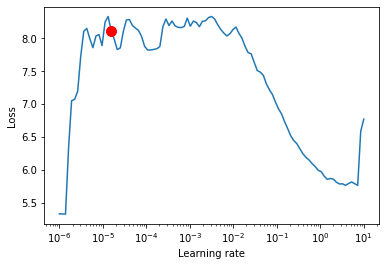

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=5.888436553555889e-06, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=1000,
    gpus=1,

    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 156.5k


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property calle

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# can be stopped at any point -- did at 24 epochs
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.1 K 
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 64.1 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 36.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidde

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
import pickle

In [ ]:




# can cancel, but wait after clicking -- take time to cancel
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100, #200,
    max_epochs=10,#50
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-05-17 19:17:26,884] A new study created in memory with name: no-name-474fd61c-0894-4a20-b0ab-c6257b575c79
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/loca

KeyError: ignored

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1.6516)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

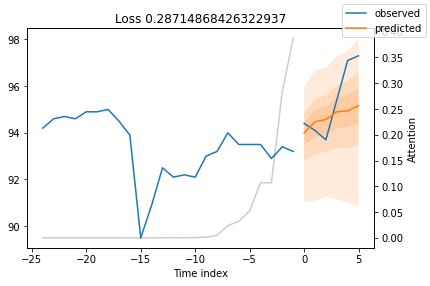

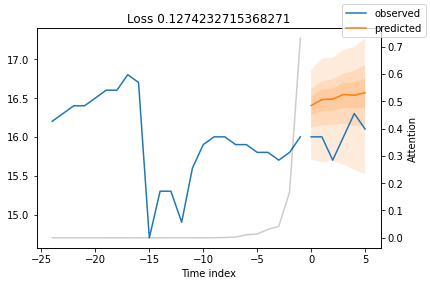

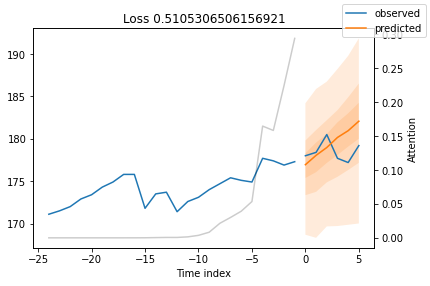

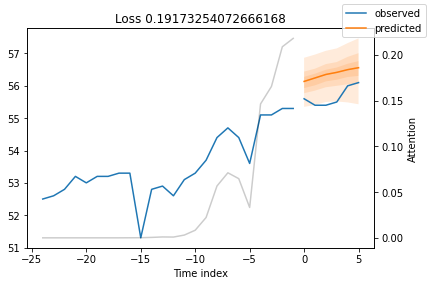

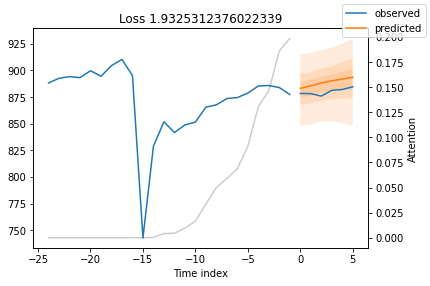

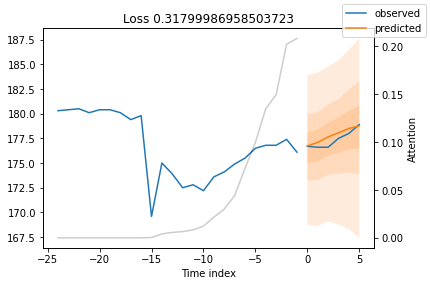

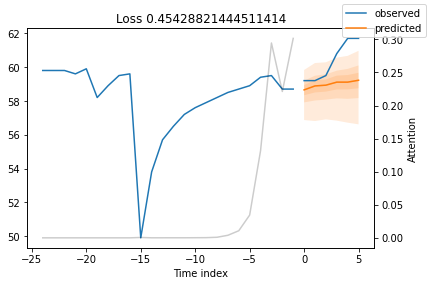

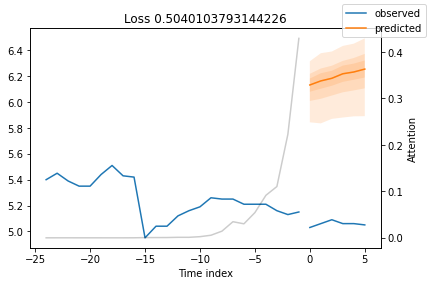

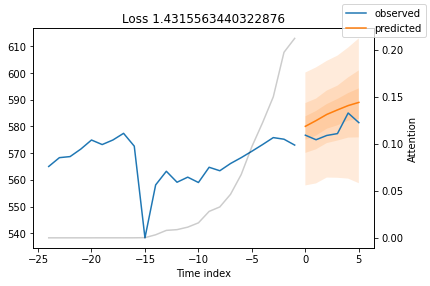

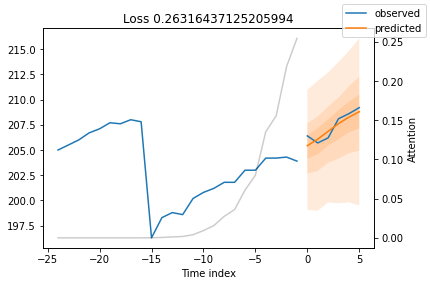

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full

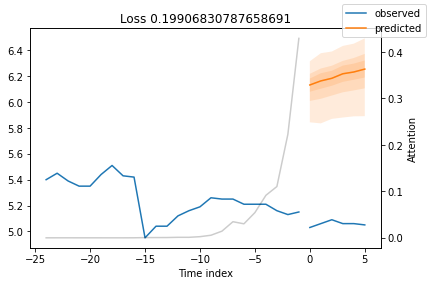

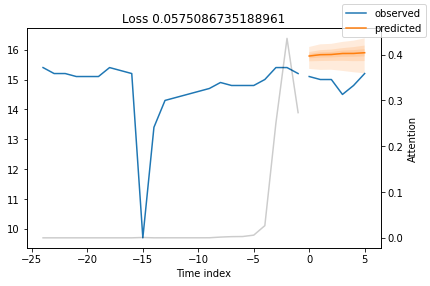

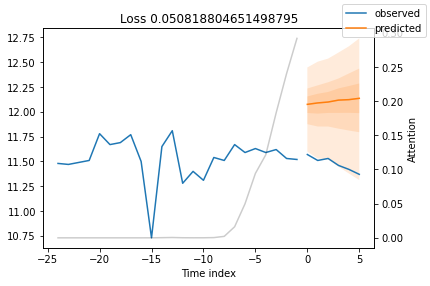

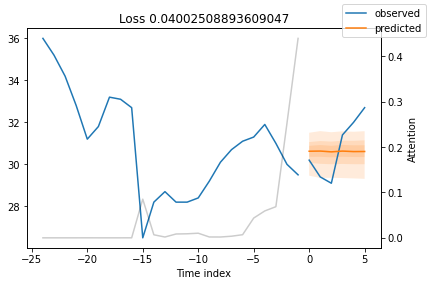

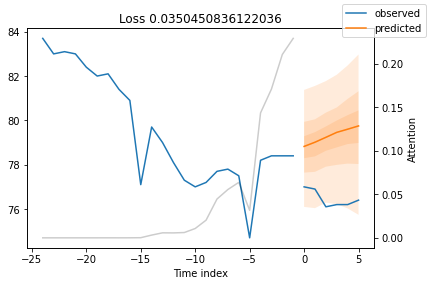

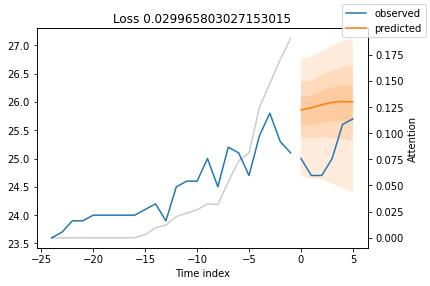

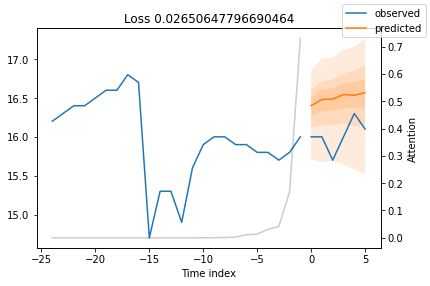

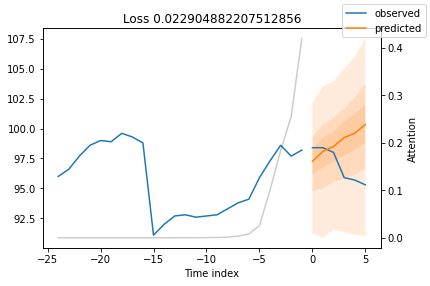

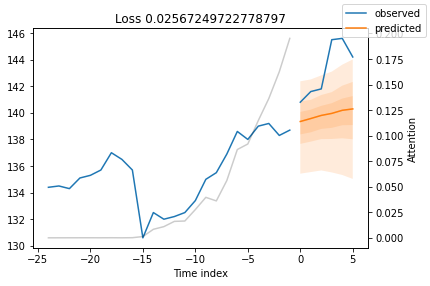

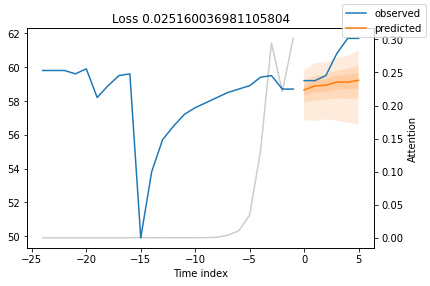

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are r

KeyboardInterrupt: ignored

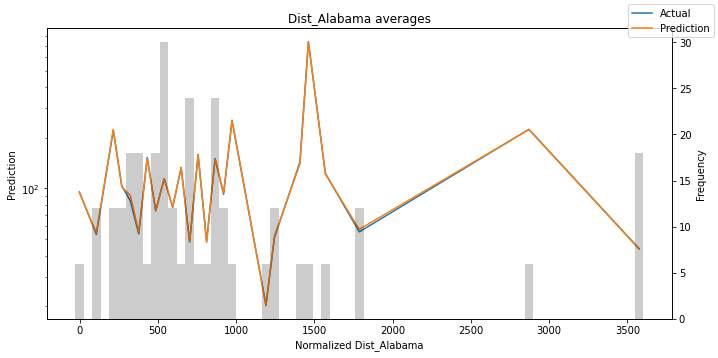

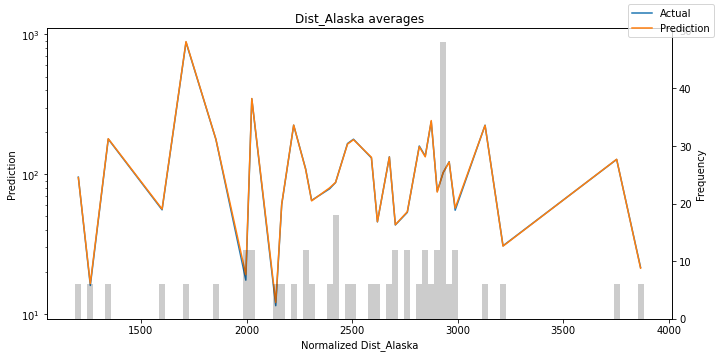

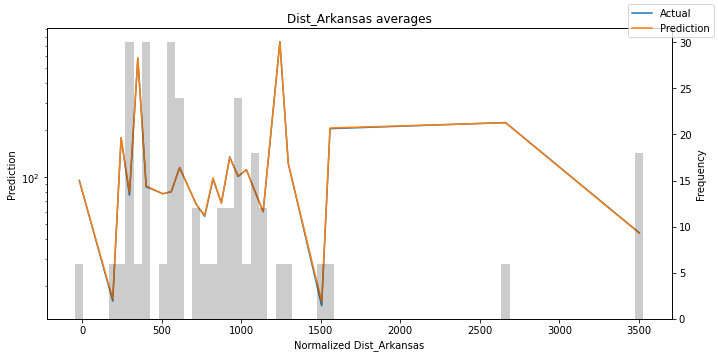

Error in callback <function flush_figures at 0x7fcd37ccd200> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.State == "California") & (x.time_idx_first_prediction == 372)),
    mode="quantiles",
)

tensor([[[842.7761, 859.2906, 866.8995, 874.9242, 880.4215, 887.4016, 904.9022],
         [845.5869, 862.6113, 870.2470, 878.2317, 883.5831, 890.6721, 908.0311],
         [851.8087, 869.5777, 876.9137, 884.3501, 889.3108, 895.8435, 912.4829],
         [848.3839, 868.2820, 876.6732, 884.1520, 890.1826, 897.9391, 915.0753],
         [845.6143, 867.4753, 877.2803, 885.9700, 893.0347, 901.6458, 919.4813],
         [844.2100, 867.4309, 877.5266, 886.5624, 894.2490, 903.9818, 922.6132]],

        [[842.8820, 859.2388, 866.7958, 874.7798, 880.2285, 887.1713, 904.6072],
         [845.7325, 862.6162, 870.2086, 878.1584, 883.4607, 890.5295, 907.8179],
         [851.9120, 869.5535, 876.8584, 884.2578, 889.1753, 895.6910, 912.2655],
         [848.4606, 868.2607, 876.6370, 884.0876, 890.0856, 897.8370, 914.9154],
         [845.6537, 867.4624, 877.2715, 885.9532, 893.0026, 901.6252, 919.4249],
         [844.2275, 867.4316, 877.5446, 886.5963, 894.2799, 904.0358, 922.6552]],

        [[843.0641, 859.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


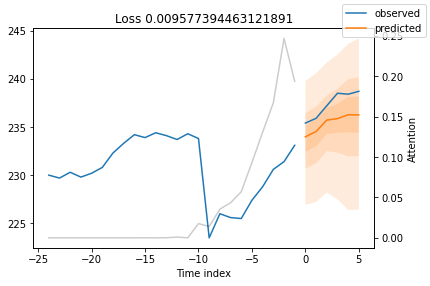

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.State == "North Carolina") & (x.time_idx_first_prediction == 372)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0, add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles));

**Importance Overall and City specific**

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x684 with 1 Axes>,
 'static_variables': <Figure size 504x1080 with 1 Axes>}

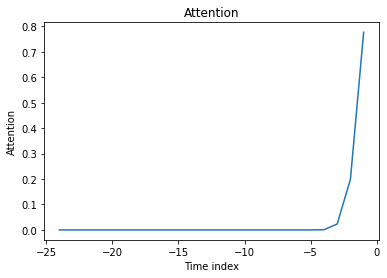

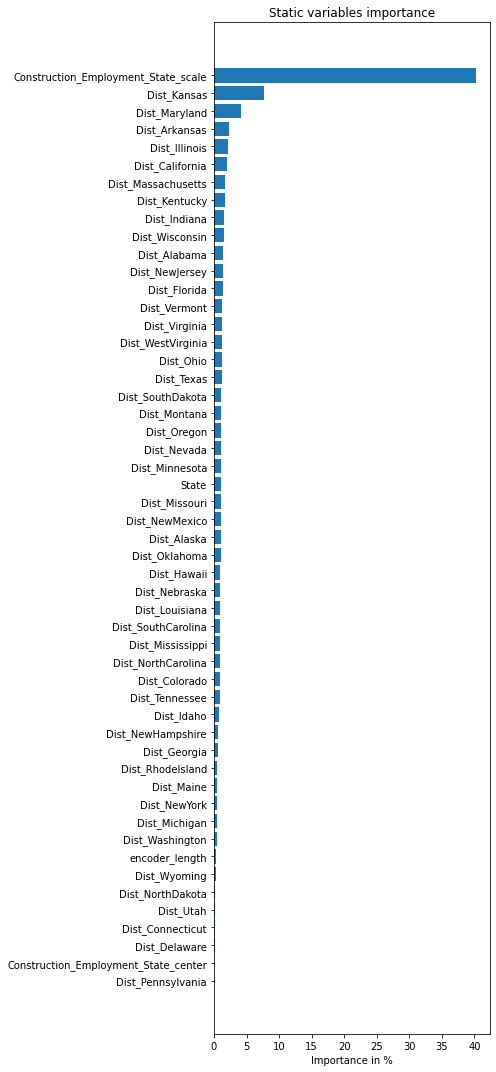

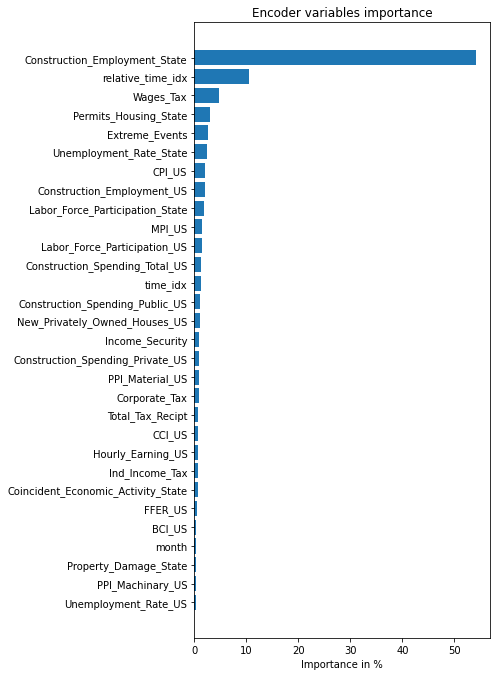

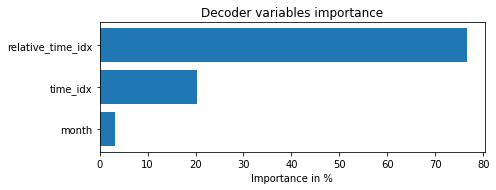

In [ ]:
interpretation = best_tft.interpret_output(raw_prediction, reduction="sum")
best_tft.plot_interpretation(interpretation)

Predict on new data


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

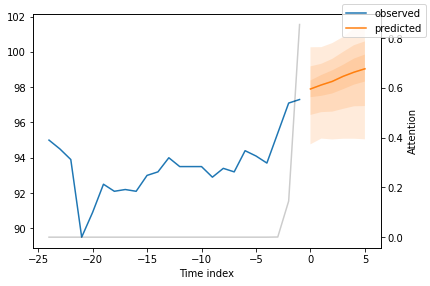

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);